# CUDA
SSSP / CC 168

* sssp-e-data: 12
* sssp-e-topo: 12
* sssp-v-data-push: 60
* sssp-v-data-pull: 24
* sssp-v-topo-push: 36
* sssp-v-topo-pull: 24

BFS CUDA 180
* sssp-e-data: 12
* sssp-e-topo: 12
* sssp-v-data-push: 60
* sssp-v-data-pull: 24
* sssp-v-topo-push: 48
* sssp-v-topo-pull: 24

TC CUDA 72
* tc-e: 36
* tc-v: 36

MIS CUDA 112
* mis-e-data: 8
* mis-e-topo: 8
* mis-v-data-push: 24
* mis-v-data-pull: 24
* mis-v-topo-push: 24
* mis-v-topo-pull: 24

PR CUDA 54
* pr-push: 18
* pr-pull: 36

# OpenMP and C++ threads

SSSP / CC 36

* e-data: 6
* e-topo: 6
* v-data-push: 10
* v-data-pull: 4
* v-topo-push: 6
* v-topo-pull: 4

BFS OpenMP 38
* e-data: 6
* e-topo: 6
* v-data-push: 10
* v-data-pull: 4
* v-topo-push: 8
* v-topo-pull: 4

MIS OpenMP 36
* mis-e-data: 6
* mis-e-topo: 6
* mis-v-data-push: 6
* mis-v-data-pull: 6
* mis-v-topo-push: 6
* mis-v-topo-pull: 6

TC OpenMP 12
* tc-e: 6
* tc-v: 6

PR OpenMP 18
pr-push: 6
pr-pull: 12


In [26]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
## constants
scatter_colors = ['r', 'b', 'y']
fsize=15
tsize=15

## configure figure scale, title, and labels
def plot_conf(y_scale, fig_title, x_label, y_label):
  plt.yscale(y_scale)
  #plt.title(fig_title, fontsize=tsize)
  plt.xlabel(x_label, fontsize=fsize)
  plt.ylabel(y_label, fontsize=fsize)
  plt.show()

## filter data according to key (i.e., tag name)
def filter_data(raw_df, key, no_cuato, thread_only, warp_only, block_only, old_name, new_name):
  df = (raw_df[raw_df['filename'].str.contains(key)]).rename({old_name:new_name}, axis='columns')
  if no_cuato:
    df = (df[df['filename'].str.contains('CudaAtomic') == False])
  if thread_only:
    df = (df[df['filename'].str.contains('Thread')])
  if warp_only:
    df = (df[df['filename'].str.contains('Warp')])
  if block_only:
    df = (df[df['filename'].str.contains('Block')])
  return df.reset_index()

## generate dict{filename: throughputs}
def generate_dict(df, col_name, tag_name):
  ratio_df = df.loc[:, ['filename', col_name]]
  tmp_dict = ratio_df.set_index('filename').T.to_dict('list')
  new_key_list = []
  key_word = ['.cu', '.cpp', '_NoBoundsBug1','_NoBoundsBug2','_NoFieldBug']

  for key in tmp_dict.keys():
    if '_Topo' in key and '_NonDup' in key:
      key = key.replace('_NonDup', '')

    if '_push' in key:
      key = key.replace('_push', '_Push')
    if '_pull' in key:
      key = key.replace('_pull', '_Pull')
    new_key = key.replace(tag_name + '_', '_')
    new_key = new_key.replace(tag_name + '.', '.')
    for word in key_word:
      if word in key:
        new_key = new_key.replace(word, '')
    # new_key = key.split('_')


    if 'Dup' in tag_name:
      new_key = new_key.replace('_Data', '')
    if 'PR' in key and 'Pull' in tag_name:
      new_key = new_key.replace('_Determ', '')

    new_key_list.append(new_key)

  # print(new_key_list)
  return (dict(zip(new_key_list, list(tmp_dict.values()))))

## generate figure title
def generate_title(algo_name, no_cuato, thread_only, warp_only, block_only, device, tags):
  name = algo_name.replace('_', '')
  name = name + '_' + device
  if no_cuato:
    name += '_atomic'
  if thread_only:
    name += '_thread'
  if warp_only:
    name += '_warp'
  if block_only:
    name += '_block'

  return name

## compute tags[0] / tags[1]
def compute_ratio(dict1, dict2, tmp_col_name):
  ratio_dict = {}
  # val1, val2
  if len(dict1) < len(dict2):
    for key in dict1.keys():
      if key in dict2.keys():
        val1 = (dict1[key])[0]
        val2 = (dict2[key])[0]
        if val2 == 0.000000:
          val2 = 0.0000004
        ratio_dict[key] = val1 / val2
  else:
    for key in dict2.keys():
      if key in dict1.keys():
        val1 = (dict1[key])[0]
        val2 = (dict2[key])[0]
        if val2 == 0.000000:
          val2 = 0.0000004
        ratio_dict[key] = val1 / val2

  df = pd.DataFrame()
  df['filename'] = ratio_dict.keys()
  df[tmp_col_name] = ratio_dict.values()
  df['algorithm'] = tmp_col_name
  return df



In [28]:
import seaborn as sns
import plotly.graph_objects as go

# violin plot using seaborn
def sns_vioplot(ratio_df_final, ratio_col_names, y_scale, fig_title, fsize):
    sns.violinplot(data=ratio_df_final[ratio_col_names], cut=0, scale='width', inner='box', color=None, linewidth=3)
    plt.axhline(y=1, color='#0030D7', linestyle='--', linewidth=1.4, label='4')
    plt.grid()
    plt.yscale(y_scale)
    plt.xlabel('Codes', fontsize=fsize)
    plt.ylabel('Ratio', fontsize=fsize)
    plt.show()

# violin plot using plotly
def go_vioplot(ratio_df_final, ratio_col_names):
    fig = go.Figure()
    for col_name in ratio_col_names:
      fig.add_trace(go.Violin(y=ratio_df_final[col_name],
                            name=col_name,
                            box_visible=True,
                            line_width=3,
                            meanline_visible=True,))
    fig.update_yaxes(type="log")
    fig.update_layout(
    autosize=False,
    width=450,
    height=300,
    xaxis=dict(title = 'Codes'),
    yaxis=dict(title = 'Ratio'),
    showlegend=False,
    margin_b=5,
    margin_l=5,
    margin_t=5,
    margin_r=5)

    fig.add_hline(y=1, line_width=1.5, line_dash="dash")
    fig.show()

In [48]:
## plot the throughputs for each input

import plotly.express as px


def plot_input_data(algos, inputs, tags, csv_files, no_cuato, thread_only, warp_only, block_only, y_scale, device):
  w, h = 1 * len(algos), 2
  for j in range(len(inputs)):

    fig_title = generate_title(inputs[j], no_cuato, thread_only, warp_only, block_only, device, tags)
    print(fig_title)
    df_list = []
    col_names = []
    ratio_df_list = []
    ratio_col_names = []

    plt.figure(figsize=(w, h))

    for i in range(len(algos)):
      x = ['filename', algos[i]]
      raw_df = pd.read_csv(csv_files[i][j], usecols = x)
      ratio_dicts = []

      for k in range(len(tags)):
        aname = algos[i]
        aname = aname.upper()
        col_name = aname + tags[k]

        if 'Thread' in tags[k]:
          col_name = aname + '_T'
        if '_Warp' in tags[k]:
          col_name = aname + '_W'
        if 'Block' in tags[k]:
          col_name = aname + '_B'

        if 'GlobalAdd' in tags[k]:
          col_name = aname + '_Glo'
        if 'BlockAdd' in tags[k]:
          col_name = aname + '_Blk'
        if 'Reduction' in tags[k]:
          col_name = aname + '_Red'



        if 'ReadWrite' in tags[k]:
          col_name = algos[i] + '_RW'
        if 'ReadModifyWrite' in tags[k]:
          col_name = algos[i] + '_RMW'
        key = tags[k] + '_' + '|' + tags[k] + '.'
        if algos[i] == 'mis' and 'NonDup' in key:
          key = '_Data'
        if algos[i] == 'pr' and 'Pull' in key:
          raw_df = filter_data(raw_df, '_Determ', no_cuato, thread_only, warp_only, block_only, algos[i], col_name)
        if algos[i] == 'cc' or algos[i] == 'bfs' or algos[i] == 'sssp':
          # if 'Push' in key:
          #   raw_df = filter_data(raw_df, '_ReadWrite', no_cuato, thread_only, warp_only, block_only, algos[i], col_name)
          if 'Pull' in key:
            raw_df = filter_data(raw_df, '_NonDeterm', no_cuato, thread_only, warp_only, block_only, algos[i], col_name)

        # filter data according to tags[k]
        new_df = filter_data(raw_df, key, no_cuato, thread_only, warp_only, block_only, algos[i], col_name)

        # generate throughputs dict for computing ratio tags[0] / tags[1]
        if len(tags) == 2:
          tmp_dict = generate_dict(new_df, col_name, tags[k])
          ratio_dicts.append(tmp_dict)

        # save tags[k] throughputs
        df_list.append(new_df)
        col_names.append(col_name)

      if (len(tags) == 2):
        tmp_col_name = algos[i]
        tmp_col_name = tmp_col_name.upper()
        ratio_col_names.append(tmp_col_name)
        tmp_df = compute_ratio(ratio_dicts[0], ratio_dicts[1], tmp_col_name)
        ratio_df_list.append(tmp_df)

    ## create dataframe for algos[i]
    df_final = pd.concat(df_list, axis=1)

    box_props = dict(linestyle='-', linewidth=3)
    median_props = dict(linestyle='-', linewidth=3)
    whisker_props = dict(linestyle='-', linewidth=3)
    ## default box plot
    df_final.boxplot(column =col_names, figsize=(w, h), whiskerprops=whisker_props, medianprops=median_props, boxprops=box_props, fontsize=fsize)

    # scatter plot
    for i in range(len(col_names)):
      col = col_names[i]
      # print(col)
      y = df_final[col].tolist()
      x = np.random.normal(i+1, 0.04, size=len(y))
      plt.scatter(x, y, color=scatter_colors[i % len(tags)])


    plot_conf(y_scale, fig_title, 'Codes', 'Throughput (GEdges/s)')

    ##  create dataframe for ratios
    if len(tags) == 2:
      # print(ratio_df_list)
      ratio_df_final = pd.concat(ratio_df_list, axis=1)
      # print(ratio_df_final)

      ratio_df_final.boxplot(column=ratio_col_names, figsize=(w, h), whiskerprops=whisker_props, medianprops=median_props, boxprops=box_props, fontsize=fsize)
      plt.axhline(y=1, color='#0030D7', linestyle='--', linewidth=1.4, label='4')
      plot_conf(y_scale, fig_title, 'Codes', 'Ratio')

    new_ratio_df = pd.DataFrame()
    for i in range(len(ratio_df_list)):
      df = ratio_df_list[i]
      name = ratio_col_names[i]

      tdf = df.rename({name:'Ratio'}, axis='columns')
      new_ratio_df = pd.concat([new_ratio_df, tdf], ignore_index=True)
    # print(new_ratio_df)
    # sns.violinplot(data=new_ratio_df, x='algorithm', y='Ratio', cut=0, scale='width', inner='box', color=None, linewidth=3)

    if len(tags) == 2:

      fig, ax = plt.subplots(figsize=(w, h))
      sns.boxenplot(data=new_ratio_df, x='algorithm', y='Ratio', ax=ax)
      plt.axhline(y=1, color='#0030D7', linestyle='--', linewidth=1.4, label='4')
      plt.grid()
      plt.yscale(y_scale)
      plt.xlabel('Codes', fontsize=12)
      plt.ylabel('Ratio', fontsize=12)
      fig.savefig(tags[0] + '-and-' + tags[1] + '-cuda.pdf', dpi=fig.dpi)








In [30]:
## declare inputs and data links
inputs = ['_2d2e', '_co', '_ny',  '_rmat', '_soc']

bfs_cuda = ['../data/bfs_cuda.csv']
cc_cuda = ['../data/cc_cuda.csv']
mis_cuda = ['../data/mis_cuda.csv']
pr_cuda = ['../data/pr_cuda.csv']
sssp_cuda = ['../data/sssp_cuda.csv']
tc_cuda = ['../data/tc_cuda.csv']

bfs_tv_cuda = ['../data/bfs_cuda_16.csv']
cc_tv_cuda = ['../data/cc_cuda_16.csv']
mis_tv_cuda = ['../data/mis_cuda_16.csv']
pr_tv_cuda = ['../data/pr_cuda_16.csv']
sssp_tv_cuda = ['../data/sssp_cuda_16.csv']
tc_tv_cuda = ['../data/tc_cuda_16.csv']

bfs_rtx_cuda = ['../data/bfs_cuda_32.csv']
cc_rtx_cuda = ['../data/cc_cuda_32.csv']
mis_rtx_cuda = ['../data/mis_cuda_32.csv']
pr_rtx_cuda = ['../data/pr_cuda_32.csv']
sssp_rtx_cuda = ['../data/sssp_cuda_32.csv']
tc_rtx_cuda = ['../data/tc_cuda_32.csv']

Atomic/CudaAtomic__RTX 3090


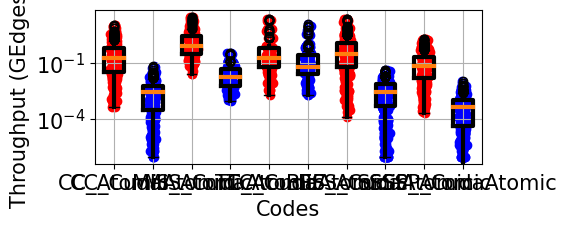

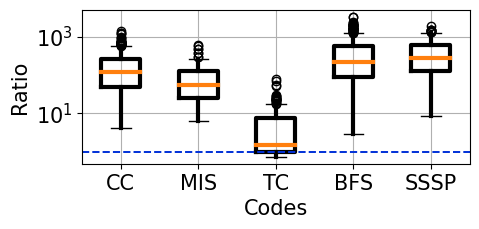

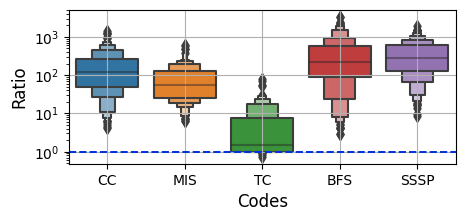

In [31]:
# Figure 1(a) in the paper
# all values
## plot_input_data(algos, inputs, tags, csv_files, no_cuato, thread_only, warp_only, block_only, y_scale)
plot_input_data(['cc', 'mis', 'tc', 'bfs', 'sssp'], ['_Atomic/CudaAtomic'], ['_Atomic', '_CudaAtomic'], [cc_rtx_cuda, mis_rtx_cuda, tc_rtx_cuda, bfs_rtx_cuda, sssp_rtx_cuda], False, False, False, False, "log", '_RTX 3090')

Atomic/CudaAtomic__Titan V


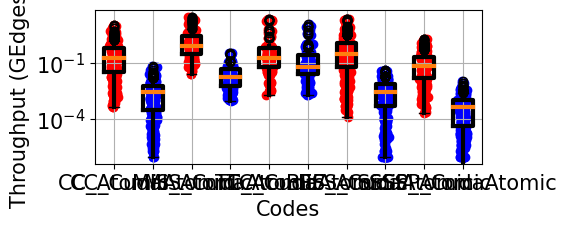

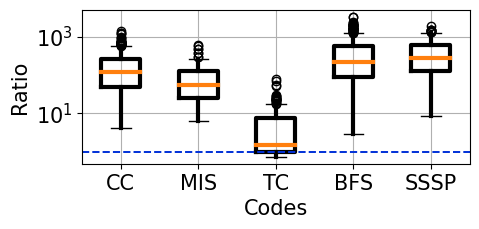

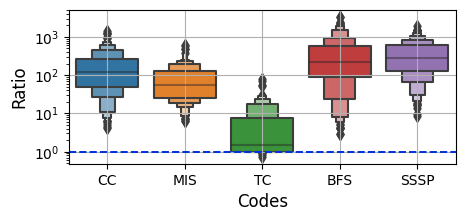

In [32]:
# Figure 1(b) in the paper
## plot_input_data(algos, inputs, tags, csv_files, no_cuato, thread_only, warp_only, block_only, y_scale)
plot_input_data(['cc', 'mis', 'tc', 'bfs', 'sssp'], ['_Atomic/CudaAtomic'], ['_Atomic', '_CudaAtomic'], [cc_tv_cuda, mis_tv_cuda, tc_tv_cuda, bfs_tv_cuda, sssp_tv_cuda], False, False, False, False, "log", '_Titan V')

all_CUDA_atomic_thread


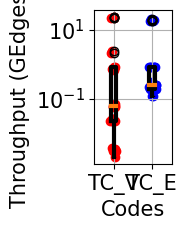

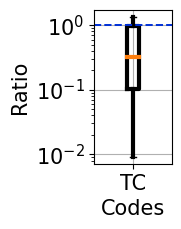

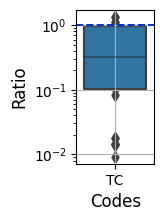

In [33]:
# Figure 2(c) in the paper
## plot_input_data(algos, inputs, tags, csv_files, no_cuato, thread_only, warp_only, block_only, y_scale)
plot_input_data(['tc'], ['_all'], ['_V', '_E'], [tc_cuda], True, True, False, False, "log", 'CUDA')

all_CUDA_atomic


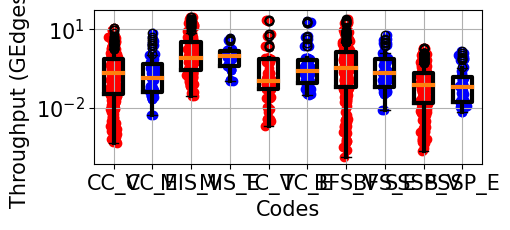

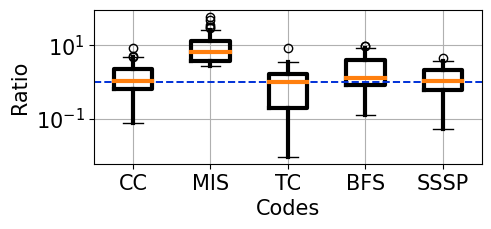

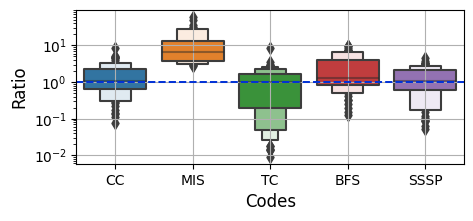

In [34]:
# Figure 2(a) in the paper
plot_input_data(['cc', 'mis', 'tc', 'bfs', 'sssp'], ['_all'], ['_V', '_E'], [cc_cuda, mis_cuda, tc_cuda, bfs_cuda, sssp_cuda], True, False, False, False, 'log', 'CUDA')

all_CUDA_atomic


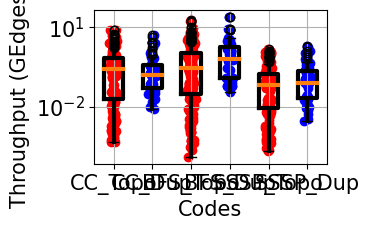

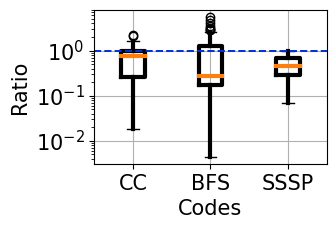

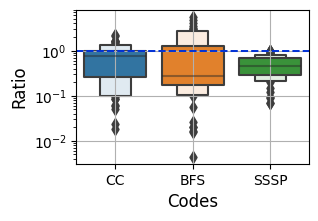

In [36]:
## Figure 3(a) in the paper
## plot_input_data(algos, inputs, tags, csv_files, no_cuato, thread_only, warp_only, block_only, y_scale)
plot_input_data(['cc', 'bfs', 'sssp'], ['_all'], ['_Topo', '_Dup'], [cc_cuda, bfs_cuda, sssp_cuda], True, False, False, False, "log", 'CUDA')

all_CUDA_atomic


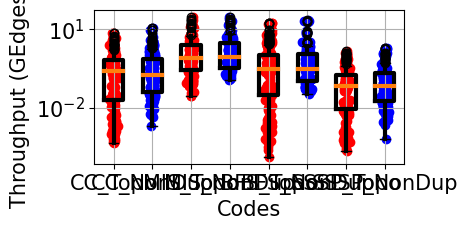

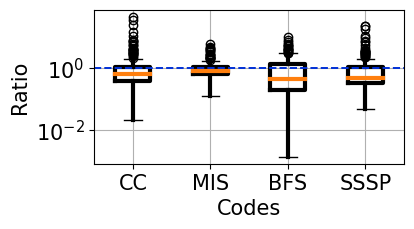

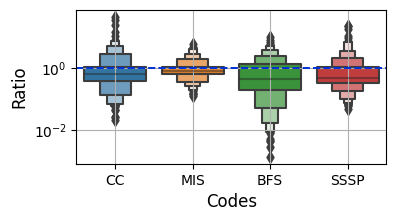

In [38]:
## Figure 4(a) in the paper
## plot_input_data(algos, inputs, tags, csv_files, no_cuato, thread_only, warp_only, block_only, y_scale)
plot_input_data(['cc', 'mis', 'bfs', 'sssp'], ['_all'], ['_Topo', '_NonDup'], [cc_cuda, mis_cuda, bfs_cuda, sssp_cuda], True, False, False, False, "log", 'CUDA')

all_CUDA_atomic


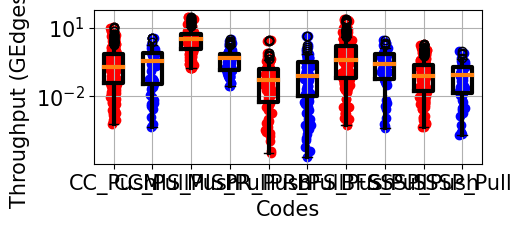

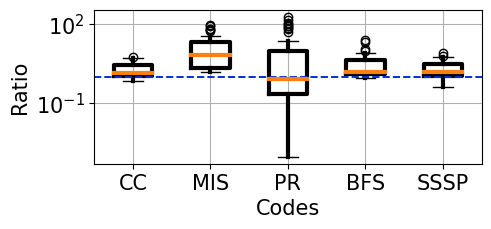

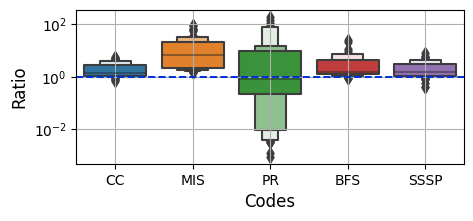

In [39]:
# Figure 5(a) in the paper
## plot_input_data(algos, inputs, tags, csv_files, no_cuato, thread_only, warp_only, block_only, y_scale)
plot_input_data(['cc', 'mis', 'pr', 'bfs', 'sssp'], ['_all'], ['_Push', '_Pull'], [cc_cuda, mis_cuda, pr_cuda, bfs_cuda, sssp_cuda], True, False, False, False, "log", 'CUDA')

all_CUDA_atomic_thread


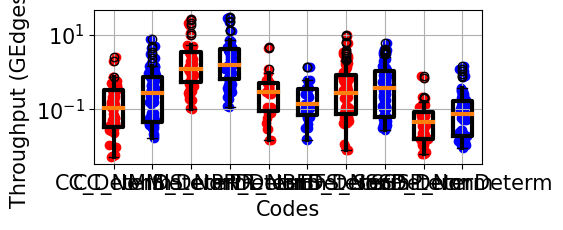

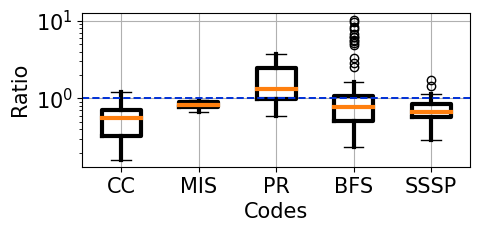

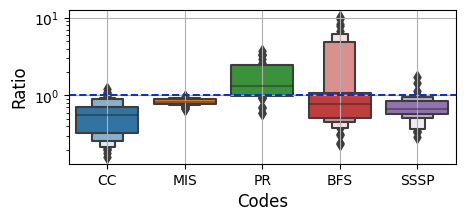

In [41]:
# Figure 7(a) in the paper
plot_input_data(['cc', 'mis', 'pr', 'bfs', 'sssp'], ['_all'], ['_Determ', '_NonDeterm'], [cc_cuda, mis_cuda, pr_cuda, bfs_cuda, sssp_cuda], True, True, False, False, "log", 'CUDA')

all_CUDA_atomic


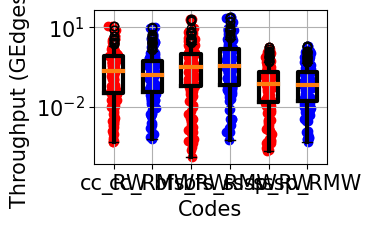

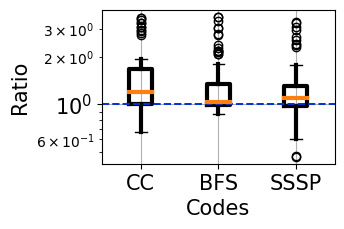

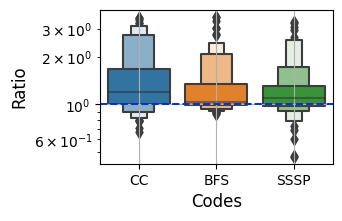

In [42]:
# Figure 6(a) in the paper
plot_input_data(['cc','bfs', 'sssp'], ['_all'], ['_ReadWrite', '_ReadModifyWrite'], [cc_cuda, bfs_cuda, sssp_cuda], True, False, False, False, "log", 'CUDA')

all_CUDA_atomic


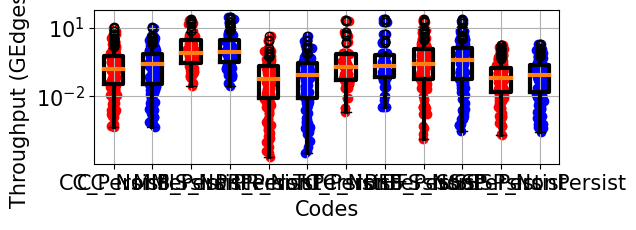

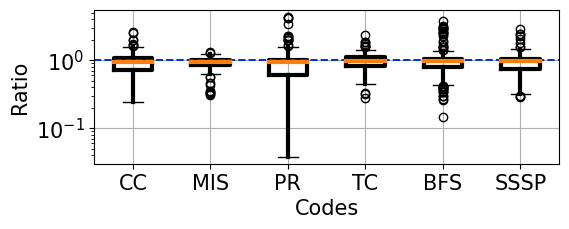

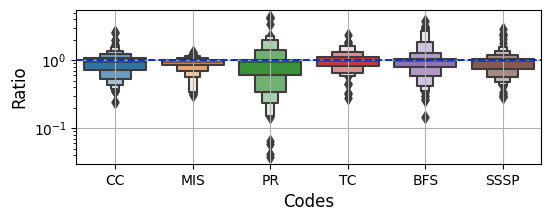

In [50]:
# Figure 8 in the paper
plot_input_data(['cc', 'mis', 'pr', 'tc', 'bfs', 'sssp'], ['_all'], ['_Persist', '_NonPersist'], [cc_cuda, mis_cuda, pr_cuda, tc_cuda, bfs_cuda, sssp_cuda], True, False, False, False, "log", 'CUDA')
# plot_input_data(['cc', 'mis', 'pr', 'tc', 'bfs', 'sssp'], ['_all'], ['_Persist', '_NonPersist'], [cc_cuda_tv, mis_cuda_tv, pr_cuda_tv, tc_cuda_tv, bfs_cuda_tv, sssp_cuda_tv], True, False, False, False, "log", 'CUDA')

all_CUDA_atomic


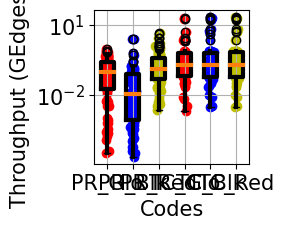

In [49]:
# Figure 10
plot_input_data(['pr','tc'], ['_all'], ['_GlobalAdd', '_BlockAdd', '_Reduction'], [pr_cuda, tc_cuda], True, False, False, False, "log", 'CUDA')

all_CUDA_atomic


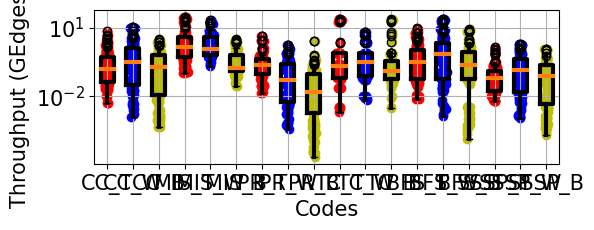

In [51]:
# Figure 9 in the paper
plot_input_data(['cc', 'mis', 'pr', 'tc', 'bfs', 'sssp'], ['_all'], ['_Thread', '_Warp', '_Block'], [cc_cuda, mis_cuda, pr_cuda, tc_cuda, bfs_cuda, sssp_cuda], True, False, False, False, "log", 'CUDA')